# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.calibration import CalibratedClassifierCV

from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, plot_roc_curve, roc_curve, auc

from sklearn.model_selection import train_test_split, GridSearchCV 
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, BalancedBaggingClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Business Understanding
The purpose of the analysis is to gain more understanding of Arvato customers compared to Germany population. There are two main objectives:

1. The first objective is to obtain customer segments of Arvato customers and analyse how customers are similar to or differ the general population at large.

2. Te second objective is to create a model to classifiy which targets of a mail campaign will be become customers.


## Data Understanding
We have 4 Datasets:
- **Azdias**: includes demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- **Customers**: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- **Mailout train**: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- **Mailout test**: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).



In [2]:
# load in the data
azdias = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#### General population

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


We see some null values let's check how many of the are.

In [5]:
def show_null_ratio(df):
    column_ratio_list = list()

    for column in df.columns:
        mask = df[column].isnull()
        null_ratio = sum(mask)/df.shape[0]
        column_ratio_list.append({'column': column, 'null_ratio': null_ratio})
    null_ratio_df = pd.DataFrame(column_ratio_list)
    return null_ratio_df

In [6]:
null_ratio_azdias = show_null_ratio(azdias)

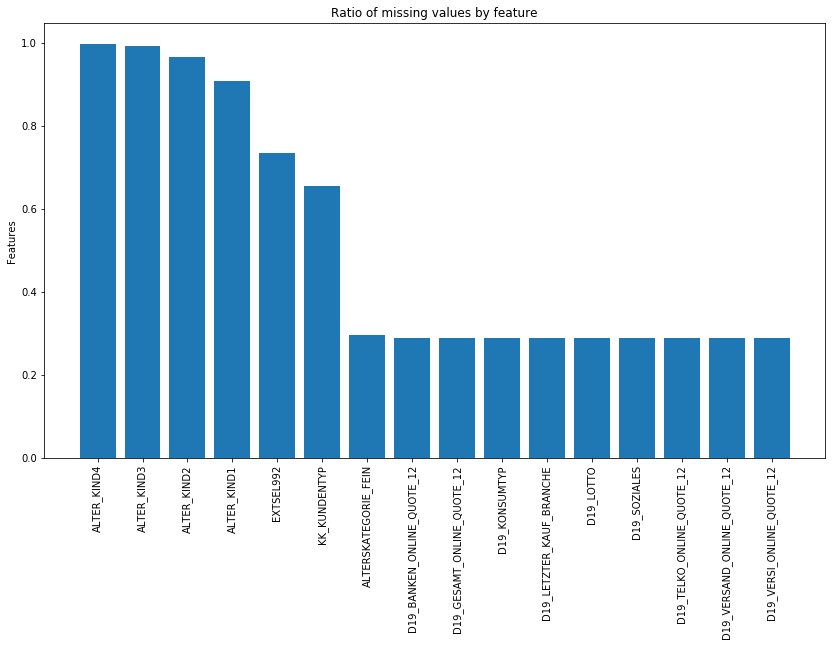

In [8]:
plt.figure(figsize=(14,8))

data = null_ratio_azdias.query('null_ratio > 0.15').sort_values('null_ratio', ascending=False)
x = data['column']
y = data['null_ratio']
plt.title('Ratio of missing values by feature')
plt.ylabel('Ratio')
plt.ylabel('Features')
plt.bar(x, y)
plt.xticks(rotation=90);

Let's analyze categorical variables

In [9]:
# Split categorical and numerical data
def split_categorical_numerical(df):
    column_names = df.columns
    dtype_mapping = dict(df.dtypes)

    categorical_vars = [c for c in column_names if dtype_mapping[c] == 'object'] 
    numerical_vars = [c for c in column_names if dtype_mapping[c] != 'object']
    return categorical_vars, numerical_vars


In [10]:
def categorical_total_values(df, categorical_vars):
    column_total_value_list = list()
    
    for var in categorical_vars:
        column_total_value_list.append({'column': var, 'total_values': df[var].unique().size})
    column_total_value_df = pd.DataFrame(column_total_value_list)
    return column_total_value_df

In [11]:
categorical_vars, numerical_vars = split_categorical_numerical(azdias)

In [12]:
categorical_total_values(azdias, categorical_vars)

,column,total_values
0,CAMEO_DEU_2015,46
1,CAMEO_DEUG_2015,20
2,CAMEO_INTL_2015,44
3,D19_LETZTER_KAUF_BRANCHE,36
4,EINGEFUEGT_AM,5163
5,OST_WEST_KZ,3


In [13]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [14]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

`CAMEO_DEUG_2015`, `CAMEO_INTL_2015` have an undocumented `XX` value.

`EINGEFUEGT_AM` has a high number of categories. Let's check it.

In [15]:
azdias['EINGEFUEGT_AM'].value_counts().nlargest(5)

1992-02-10 00:00:00    383738
1992-02-12 00:00:00    192264
1995-02-07 00:00:00     11181
2005-12-16 00:00:00      6291
2003-11-18 00:00:00      6050
Name: EINGEFUEGT_AM, dtype: int64

We check for duplicates

In [16]:
sum(azdias.duplicated(subset=['LNR']))

0

###### customers

In [17]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [18]:
sum(customers.duplicated(subset=['LNR']))

0

## Data Preparation
1. Quality Issues
    1. Column `EINGEFUEGT_AM` is a datetime. Action drop.
    2. Some columns are categorical ordinal but have numeric values to represent unknown instead os np.nan. The columns and unknown values are: 
        - `AGER_TYP`(0) 
        - `ALTERSKATEGORIE_GROB` (-1, 0)
        - `ALTER_HH` (0)
        - `ANREDE_KZ` (-1,0)
        - `BALLRAUM` (-1)
        - `CAMEO_DEUG_2015` (-1)
        - `CAMEO_INTL_2015`(-1)
        - `CJT_GESAMTTYP` (0) 
        - `KK_KUNDENTYP`(-1)
        - `EWDICHTE` (-1)
        - `FINANZTYP`(-1)
        - `FINANZ_*`(-1)
        - `GEBAEUDETYP` (-1, 0)
        - `GEOSCORE_KLS7`(-1, 0)
        - `HAUSHALTSSTRUKTUR`(-1,0)
        - `HEALTH_TYP`(-1)
        - `HH_EINKOMMEN_SCORE`(-1, 0)
        - `INNENSTADT` (-1)
        - `KBA05_BAUMAX` (-1, 0)
        - `KBA05_ANTG1`, `KBA05_ANTG2`, `KBA05_ANTG3`, `KBA05_ANTG4` (-1)
        - Rest of `KBA05_*` (-1, 9)
        - All `KBA13_*` (-1)
        - `KKK` (-1, 0)
        - `NATIONALITAET_KZ` (-1, 0)
        - `ORTSGR_KLS9` (-1)
        - `OST_WEST_KZ`(-1)
        - All `PLZ8_*`(-1)
        - `PRAEGENDE_JUGENDJAHRE`(-1, 0)
        - `REGIOTYP` (-1, 0)
        - `RETOURTYP_BK_S` (0)
        - All `SEMIO_*` (-1, 9)
        - `SHOPPER_TYP` (-1)
        - `SOHO_KZ` (-1)
        - `TITEL_KZ` (-1, 0)
        - `VERS_TYP` (-1)
        - `WOHNDAUER_2008` (-1, 0)
        - `WOHNLAGE` (-1)
        - `WACHSTUMSGEBIET_NB` (-1, 0)
        - `W_KEIT_KIND_HH` (-1, 0)
        - `ZABEOTYP` (-1, 9)
    3. `CAMEO_DEUG_2015` and `CAMEO_INTL_2015` have unknow `X` and `XX` values. After remove it could be considered an ordinal variable.
    4. Columns with high ratio of null values(>=0.5). Action drop.
    4. Columns with moderate ratio of null values (<0.5). Action impute mean for numerical and mode for categorical.


2. Other preparation issues
    1. Merge
    2. Enconding Categorical Variables
    3. Reduce High dimensionality



##### Cleaning

In [39]:
azdias_clean = azdias.copy()
customers_clean = customers.copy()

In [40]:
individual_column_nulls = [('AGER_TYP', 0), ('ALTERSKATEGORIE_GROB', -1), ('ALTERSKATEGORIE_GROB', 0)]
individual_column_nulls += [('ALTER_HH', 0), ('ANREDE_KZ', -1), ('ANREDE_KZ', 0), ('BALLRAUM', -1)]
individual_column_nulls += [('CAMEO_DEUG_2015', -1), ('CAMEO_INTL_2015', -1), ('CJT_GESAMTTYP', 0)]
individual_column_nulls += [('KK_KUNDENTYP', -1), ('EWDICHTE', -1), ('FINANZTYP', -1)]
individual_column_nulls += [('GEBAEUDETYP', -1), ('GEBAEUDETYP', 0)]
individual_column_nulls += [('HEALTH_TYP', -1)]
individual_column_nulls += [('HH_EINKOMMEN_SCORE', -1), ('HH_EINKOMMEN_SCORE', 0)]
individual_column_nulls += [('INNENSTADT', -1), ('KBA05_BAUMAX', -1), ('KBA05_BAUMAX', 0)]
individual_column_nulls += [('KBA05_ANTG1', -1), ('KBA05_ANTG2', -1), ('KBA05_ANTG3', -1), ('KBA05_ANTG4', -1)]
individual_column_nulls += [('NATIONALITAET_KZ', -1), ('NATIONALITAET_KZ', 0), ('ORTSGR_KLS9', -1)]
individual_column_nulls += [('OST_WEST_KZ', -1), ('PRAEGENDE_JUGENDJAHRE', -1), ('PRAEGENDE_JUGENDJAHRE', 0)]
individual_column_nulls += [('REGIOTYP', -1), ('REGIOTYP', 0), ('RETOURTYP_BK_S', 0), ('SHOPPER_TYP', -1)]
individual_column_nulls += [('SOHO_KZ', -1), ('TITEL_KZ', -1), ('TITEL_KZ', 0), ('VERS_TYP', -1)] 
individual_column_nulls += [('WOHNDAUER_2008', -1), ('WOHNDAUER_2008', 0), ('WOHNLAGE', -1)]
individual_column_nulls += [('W_KEIT_KIND_HH', -1), ('W_KEIT_KIND_HH', 0), ('ZABEOTYP', -1), ('ZABEOTYP', 9)]
individual_column_nulls += [('CAMEO_DEUG_2015', 'X'), ('CAMEO_INTL_2015', 'XX')]

In [41]:
# Clean methods

def clean_individual_column_nulls(df, column_items):
    for column, value in column_items:
        df.loc[df[column]==value, column] = np.nan
    return df

def clean_group_column_nulls(df, group, values, exceptions=[]):
    for value in values:
        mask = (df.columns.str.contains(group))
        columns = list(df.loc[1, mask].index.values)
        for column in columns:
            if column not in exceptions:
                df.loc[df[column]==value, column] = np.nan
    return df

def clean_dataset(df):
    df_clean = clean_individual_column_nulls(df, individual_column_nulls)
    group = 'KBA05'
    exceptions = ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4']
    values = [-1, 9]
    df_clean = clean_group_column_nulls(df_clean, group, values, exceptions)

    group = 'KBA13'
    exceptions = []
    values = [-1]
    df_clean = clean_group_column_nulls(df_clean, group, values, exceptions)

    group = 'PLZ8'
    exceptions = []
    values = [-1]
    df_clean = clean_group_column_nulls(df_clean, group, values, exceptions)

    group = 'SEMIO'
    exceptions = []
    values = [-1, 9]
    df_clean = clean_group_column_nulls(df_clean, group, values, exceptions)
    
    
    missing_value_columns = ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'KK_KUNDENTYP']
    df_clean = df_clean.drop(columns=missing_value_columns) 
    
    df_clean = df_clean.drop(columns=['EINGEFUEGT_AM'])
    categorical_vars_mail, numerical_vars_mail = split_categorical_numerical(df_clean)
    for var in categorical_vars_mail:
        df_clean[var] = df_clean[var].astype(str)
        
    df_clean['CAMEO_DEUG_2015'] = pd.to_numeric(df_clean['CAMEO_DEUG_2015'], errors='coerce')
    df_clean['CAMEO_INTL_2015'] = pd.to_numeric(df_clean['CAMEO_INTL_2015'], errors='coerce')
    df_clean['CAMEO_DEUG_2015'] = pd.to_numeric(df_clean['CAMEO_DEUG_2015'], errors='coerce')
    df_clean['CAMEO_INTL_2015'] = pd.to_numeric(df_clean['CAMEO_INTL_2015'], errors='coerce')
    
    return df_clean


In [42]:
azdias_clean = clean_dataset(azdias_clean)
customers_clean = clean_dataset(customers_clean)

##### Impute values to numerical and categorical


In [43]:
categorical_vars_clean, numerical_vars_clean = split_categorical_numerical(azdias_clean)

In [44]:
for var in categorical_vars_clean:
    azdias_clean[var] = azdias_clean[var].astype(str)

In [45]:
feature_list = categorical_vars_clean + numerical_vars_clean
azdias_clean = azdias_clean[feature_list]

In [46]:
### Same process witch customers
categorical_vars_cus, numerical_vars_cus = split_categorical_numerical(customers_clean)

for var in categorical_vars_cus:
    customers_clean[var] = customers_clean[var].astype(str)

In [47]:
column_preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_clean),
    (Pipeline([
        ('cat', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string', n_features=8)),
    ]), categorical_vars_clean),
    remainder='drop'
)




In [48]:
X = column_preprocessor.fit_transform(azdias_clean)
X.shape

(891221, 365)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [49]:
pca = PCA().fit(X)



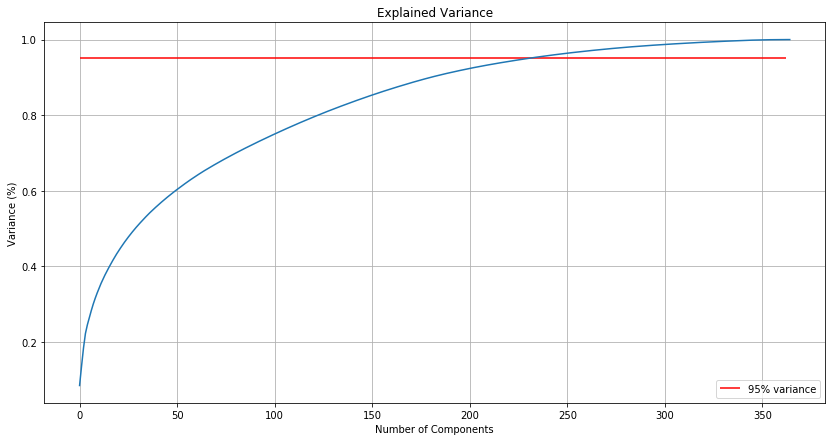

In [50]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(14, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y=0.95, xmin=0, xmax=362, colors='r', linestyles='solid', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.grid()
plt.legend(loc='lower right')
plt.show();

We can have 95% of the variance with just 225 components.

In [51]:
components = PCA(n_components=225).fit(X)


In [52]:
X_comp = components.transform(X)

In [53]:
X_comp.shape

(891221, 225)

In [54]:
# k means determine k
distortions = []
K = range(1, 22)

# We take a 10% sample of the population to determine best k
sample = X_comp[np.random.randint(X_comp.shape[0], size=50000), :]


In [55]:
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(sample)
    distortions.append(sum(np.min(cdist(sample, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / sample.shape[0])


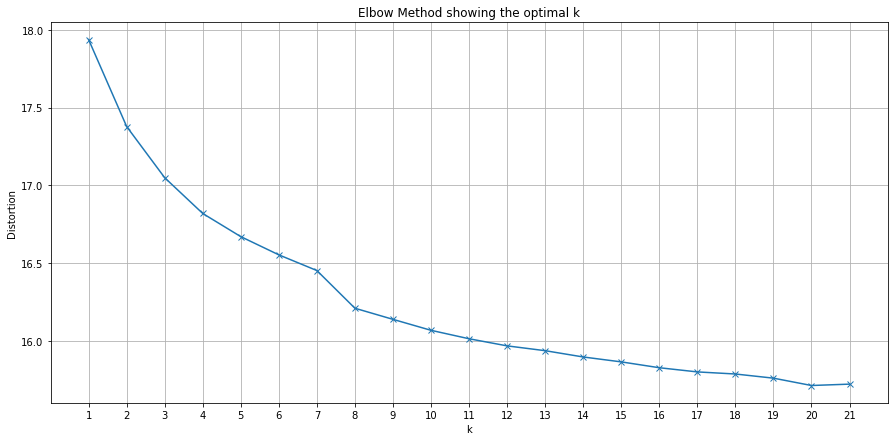

In [56]:
# Plot the elbow
plt.figure(figsize=(15, 7))
plt.plot(K, distortions, 'x-')
plt.xticks(range(1,22))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing the optimal k')
plt.grid()
plt.show();

The optimal **k** is **8**

In [57]:
categorical_vars_clean, numerical_vars_clean = split_categorical_numerical(azdias_clean)

In [58]:
all_features = numerical_vars_clean + categorical_vars_clean

In [59]:
column_preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_clean),
    (Pipeline([
        ('cat', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string', n_features=8)),
    ]), categorical_vars_clean),
    remainder='drop'
)

cluster_pipeline = Pipeline([
    ('pre', column_preprocessor),
    ('pca', PCA(n_components=225)),
    ('clu', KMeans(n_clusters=8, random_state=42)),
])

In [60]:
azdias_clusters = cluster_pipeline.fit_predict(azdias_clean)

In [61]:
customer_clusters = cluster_pipeline.predict(customers_clean[all_features])

/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [62]:
azdias_with_cluster = azdias_clean.copy()

In [63]:
azdias_with_cluster['cluster'] = azdias_clusters

In [64]:
azdias_cluster_group = azdias_with_cluster.groupby('cluster')
total_azdias_by_cluster = azdias_cluster_group['LNR'].count()

In [65]:
customer_with_cluster = customers_clean.copy()

In [66]:
customer_with_cluster['cluster'] = customer_clusters

In [67]:
customers_cluster_group = customer_with_cluster.groupby('cluster')
total_customers_by_cluster = customers_cluster_group['LNR'].count()

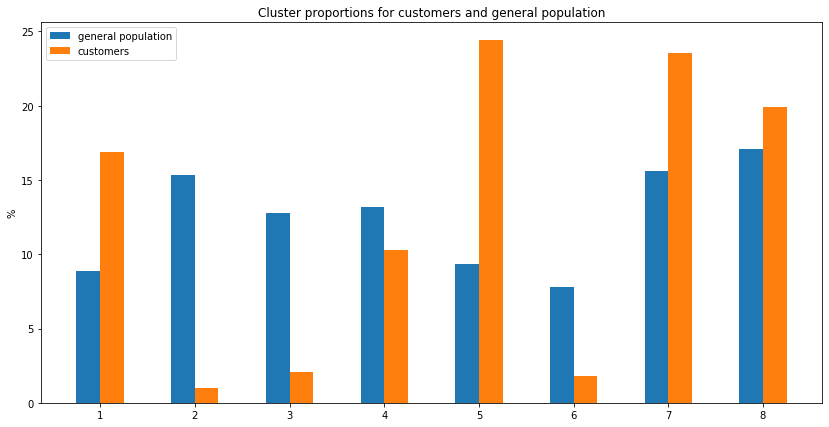

In [69]:
proportions_azdias = total_azdias_by_cluster/sum(total_azdias_by_cluster)*100
proportions_customers = total_customers_by_cluster/sum(total_customers_by_cluster)*100

x1 = np.linspace(-0.125, 6.875, 8)
x2 = np.linspace(0.125, 7.125, 8)

plt.figure(figsize=(14,7))

ax = plt.subplot()
ax1 = ax.bar(x=x1, height=proportions_azdias, width=0.25, align='center', label='general population')
ax2 = ax.bar(x=x2, height=proportions_customers, width=0.25, align='center', label='customers')

plt.ylabel('%')
plt.title('Cluster proportions for customers and general population')
plt.xticks(ticks=list(range(0, 8)), labels=list(range(1, 9)), rotation=0)
plt.legend(loc='upper left')
plt.show();

In [ ]:
def byplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()


In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [70]:
mailout_train = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
null_mailout_train = show_null_ratio(mailout_train)


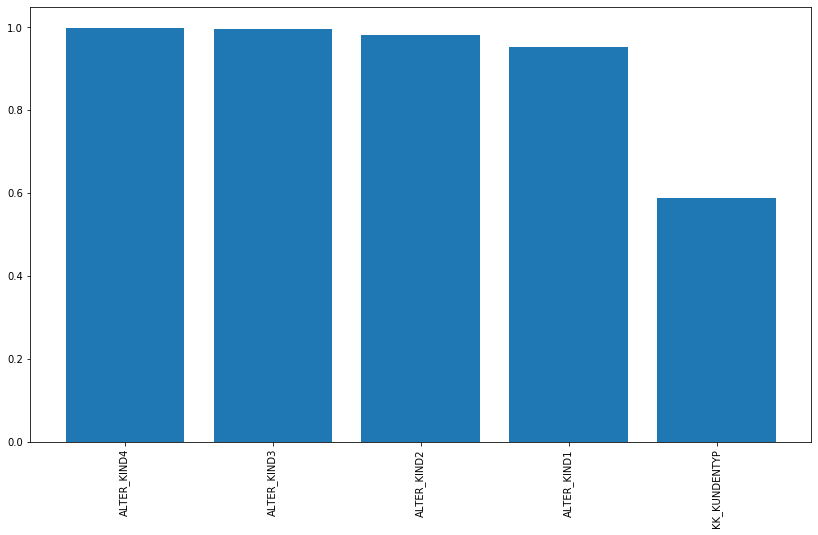

In [72]:
data = null_mailout_train.query('null_ratio > 0.5').sort_values('null_ratio', ascending=False)
x = data['column']
y = data['null_ratio']
plt.figure(figsize=(14,8))
plt.bar(x, y)
plt.xticks(rotation=90);

In [75]:
mailout_train_clean = clean_dataset(mailout_train)

In [76]:
X = mailout_train_clean.drop(columns=['RESPONSE', 'LNR'])
y = mailout_train_clean['RESPONSE']

In [77]:
X.shape

(42962, 359)

In [78]:
y.mean()

0.012383036171500396

In [81]:
categorical_vars_mail, numerical_vars_mail = split_categorical_numerical(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_mail),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string')),
    ]), categorical_vars_mail),
    remainder='drop'
)



pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest()),
    ('sam', SMOTE(random_state=42)),
    ('clf', XGBClassifier(random_state=42, 
                          max_depth=1, 
                          max_delta_step=0, 
                          colsample_bytree=1, 
                          subsample=1, 
                          min_child_weight=1))
])


In [293]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.7760617194987722
Best params: {'clf__n_estimators': 50, 'clf__scale_pos_weight': 46, 'pre__pipeline-2__enc__n_features': 12, 'sam__sampling_strategy': 0.026, 'sel__k': 180}
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      8472
           1       0.03      0.83      0.05       121

    accuracy                           0.58      8593
   macro avg       0.51      0.70      0.39      8593
weighted avg       0.98      0.58      0.72      8593

AUC: 0.7043596211926111


In [ ]:
parameters = {
    'pre__pipeline-2__enc__n_features': [12],
    'sel__k': [180],
    'sam__sampling_strategy': [0.026],
    'clf__n_estimators': [50],
    'clf__scale_pos_weight': [44, 45, 46]
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=2, verbose=2)

model.fit(X_train, y_train);

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [94]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_mail),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string')),
    ]), categorical_vars_mail),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest()),
    ('sam', SMOTE(random_state=42)),
    ('clf', VotingClassifier([
        ('xgb', XGBClassifier()),
        ('rus', RUSBoostClassifier()),
        ('brf', BalancedRandomForestClassifier()),
    ], voting='soft')),
])

In [95]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'sel', 'sam', 'clf', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__pipeline-1', 'pre__pipeline-2', 'pre__pipeline-1__memory', 'pre__pipeline-1__steps', 'pre__pipeline-1__verbose', 'pre__pipeline-1__num', 'pre__pipeline-1__sc', 'pre__pipeline-1__num__add_indicator', 'pre__pipeline-1__num__copy', 'pre__pipeline-1__num__fill_value', 'pre__pipeline-1__num__missing_values', 'pre__pipeline-1__num__strategy', 'pre__pipeline-1__num__verbose', 'pre__pipeline-1__sc__copy', 'pre__pipeline-1__sc__with_mean', 'pre__pipeline-1__sc__with_std', 'pre__pipeline-2__memory', 'pre__pipeline-2__steps', 'pre__pipeline-2__verbose', 'pre__pipeline-2__num', 'pre__pipeline-2__enc', 'pre__pipeline-2__num__add_indicator', 'pre__pipeline-2__num__copy', 'pre__pipeline-2__num__fill_value', 'pre__pipeline-2__num__missing_values', 'pre__pipeline-2__num__strategy', 'pre__pipeline-2__num__ver

In [96]:
parameters = {
    'pre__pipeline-2__enc__n_features': [12],
    'sel__k': [180],
    'sam__sampling_strategy': [0.026],
    'clf__weights': [[1, 1, 1]],
    'clf__xgb__random_state': [42],
    'clf__xgb__n_estimators': [50],
    'clf__xgb__max_depth': [1],
    'clf__xgb__max_delta_step': [0],
    'clf__xgb__colsample_bytree': [1],
    'clf__xgb__subsample': [1],
    'clf__xgb__min_child_weight': [1],
    'clf__xgb__scale_pos_weight': [45],
    'clf__rus__random_state': [42],
    'clf__rus__n_estimators': [50],
    'clf__rus__replacement': [False],
    'clf__brf__n_estimators': [200],
    'clf__brf__random_state': [42],
    'clf__brf__max_depth': [4],
    'clf__brf__max_samples': [0.05],
    'clf__brf__class_weight': [{0:0.9, 1:1}],
    'clf__brf__max_features': [0.5],
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=4, verbose=2)

model.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.8min finished


In [97]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.7724357897169832
Best params: {'clf__brf__class_weight': {0: 0.9, 1: 1}, 'clf__brf__max_depth': 4, 'clf__brf__max_features': 0.5, 'clf__brf__max_samples': 0.05, 'clf__brf__n_estimators': 200, 'clf__brf__random_state': 42, 'clf__rus__n_estimators': 50, 'clf__rus__random_state': 42, 'clf__rus__replacement': False, 'clf__weights': [1, 1, 1], 'clf__xgb__colsample_bytree': 1, 'clf__xgb__max_delta_step': 0, 'clf__xgb__max_depth': 1, 'clf__xgb__min_child_weight': 1, 'clf__xgb__n_estimators': 50, 'clf__xgb__random_state': 42, 'clf__xgb__scale_pos_weight': 45, 'clf__xgb__subsample': 1, 'pre__pipeline-2__enc__n_features': 12, 'sam__sampling_strategy': 0.026, 'sel__k': 180}
              precision    recall  f1-score   support

           0       1.00      0.57      0.72      8472
           1       0.03      0.83      0.05       121

    accuracy                           0.57      8593
   macro avg       0.51      0.70      0.39      8593
weighted avg       0.98      0.57      0.7

In [415]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.7719628469376499
Best params: {'clf__weights': [1, 0.7, 0.7], 'pre__pipeline-2__enc__n_features': 12, 'sam__sampling_strategy': 0.026, 'sel__k': 180}
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      8472
           1       0.03      0.83      0.05       121

    accuracy                           0.58      8593
   macro avg       0.51      0.70      0.39      8593
weighted avg       0.98      0.58      0.72      8593

AUC: 0.703120244422073


In [494]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_mail),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string')),
    ]), categorical_vars_mail),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest()),
    ('sam', SMOTE()),
    ('clf', SGDClassifier(random_state=42, loss='log', penalty='elasticnet', l1_ratio=0.7, class_weight={0:0.01, 1:1})),
])


In [497]:
parameters = {
    'sel__k': [180],
    'sam__sampling_strategy': [0.026],
    'clf__l1_ratio': [0.7],
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=4, verbose=2)

model.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   47.5s finished
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [498]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.6591471676168688
Best params: {'clf__l1_ratio': 0.7, 'sam__sampling_strategy': 0.026, 'sel__k': 180}
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      8472
           1       0.02      0.87      0.04       121

    accuracy                           0.39      8593
   macro avg       0.51      0.63      0.30      8593
weighted avg       0.98      0.39      0.55      8593

AUC: 0.6265188584271768


In [84]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_mail),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string')),
    ]), categorical_vars_mail),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest()),
    ('clf', RUSBoostClassifier(random_state=42)),
])


In [87]:
parameters = {
    'sel__k': [180],
    'clf__n_estimators': [50],
    'clf__replacement': [False],

}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=4, verbose=2)

model.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   55.4s finished
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [88]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.6623903807830198
Best params: {'clf__n_estimators': 50, 'clf__replacement': False, 'sel__k': 180}
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      8472
           1       0.02      0.51      0.04       121

    accuracy                           0.65      8593
   macro avg       0.50      0.58      0.41      8593
weighted avg       0.98      0.65      0.77      8593

AUC: 0.5816232762859083


In [89]:
preprocessor = make_column_transformer(
    (Pipeline([
        ('num', SimpleImputer()),
        ('sc', StandardScaler()),
    ]), numerical_vars_mail),
    (Pipeline([
        ('num', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('enc', FeatureHasher(input_type='string')),
    ]), categorical_vars_mail),
    remainder='drop'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('sel', SelectKBest()),
    ('sam', SMOTE(random_state=42)),
    ('clf', BalancedRandomForestClassifier(random_state=42)),
])

In [90]:
parameters = {
    'sel__k': [180],
    'clf__min_weight_fraction_leaf': [0.0],
    'sam__sampling_strategy': [0.026],
    'clf__ccp_alpha': [0.0],
    'clf__max_depth': [4],
    'clf__n_estimators': [50, 200],
    'clf__max_samples': [0.05],
    'clf__class_weight': [{0:0.9, 1:1}],
    'clf__max_features': [0.5]
}

model = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=4, verbose=2)

model.fit(X_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [91]:
print("Best score: %s" % model.best_score_)
print("Best params: %s" % model.best_params_)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print("AUC: %s" % auc(fpr, tpr))


Best score: 0.7661671149812083
Best params: {'clf__ccp_alpha': 0.0, 'clf__class_weight': {0: 0.9, 1: 1}, 'clf__max_depth': 4, 'clf__max_features': 0.5, 'clf__max_samples': 0.05, 'clf__min_weight_fraction_leaf': 0.0, 'clf__n_estimators': 200, 'sam__sampling_strategy': 0.026, 'sel__k': 180}
              precision    recall  f1-score   support

           0       1.00      0.56      0.72      8472
           1       0.03      0.83      0.05       121

    accuracy                           0.56      8593
   macro avg       0.51      0.70      0.38      8593
weighted avg       0.98      0.56      0.71      8593

AUC: 0.6971594323351986


In [164]:
X_train.shape

(34369, 366)

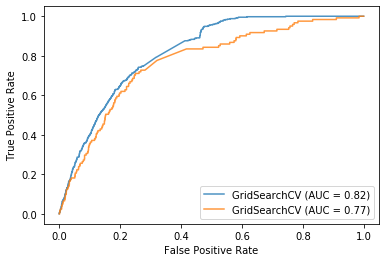

In [98]:
ax = plt.gca()
plot_roc_curve(model, X_train, y_train, ax=ax, alpha=0.8)
plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8);


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [99]:
mailout_test = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [100]:
mailout_test.shape

(42833, 366)

In [102]:
mailout_test_clean = clean_dataset(mailout_test)

In [103]:
mailout_test_clean.shape

(42833, 360)

In [104]:
y_score = model.predict_proba(mailout_test_clean)

/Users/eduardoburgoa/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [105]:
y_score[:, 1].mean()

0.4195245052335746

In [106]:
competition = pd.DataFrame()

In [107]:
competition['LNR'] = mailout_test_clean['LNR']
competition['RESPONSE'] = y_score[:, 1]

In [108]:
competition.to_csv('competition.csv', index=False)

In [223]:
competition.shape

(42833, 2)